# **Deep Learning Project** - Aerial Perspective Object Detection
SEP 769 - Group 2

In [ ]:
#About semantic segmentation: https://www.jeremyjordan.me/semantic-segmentation/
#TF Tutorial: https://www.tensorflow.org/tutorials/images/segmentation
#TF load and process images: https://www.tensorflow.org/tutorials/load_data/images

from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt

#%cd '/content/gdrive/Shareddrives/SEP_769/dataset/semantic_drone_dataset/original_images/'
#%ls
#!unzip '/content/gdrive/Shareddrives/SEP_769/archive.zip'
#Variable Locations - Kaggle
#Original Images: /content/gdrive/dataset/emantic_drone_dataset/original_images
#Original Images as Greyscale Segmentation Maps: /content/gdrive/dataset/semantic_drone_dataset/label_images_semantic
#Original Images as RGB Segmentation Maps: /content/gdrive/dataset/RGB_color_image_masks/RGB_color_image_masks
#Variable Locations - Requested Dataset
#Original Images: /content/gdrive/dataset/semantic_drone_dataset/training_set/images
#Original Images as RGB Segmentation Maps: /content/gdrive/dataset/semantic_drone_dataset/training_set/gt/semantic/label_images 
#Original Image labels and locations: /content/gdrive/dataset/semantic_drone_dataset/training_set/gt/semantic/label_me_xml

original_images_path = '/content/gdrive/Shareddrives/SEP_769/dataset/semantic_drone_dataset/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/dataset/semantic_drone_dataset/label_images_semantic/'


image_count = len(fnmatch.filter(os.listdir(original_images_path), '*.jpg'))
print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_images_path))

image_count = len(fnmatch.filter(os.listdir(original_semantic_path), '*.png'))
print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_semantic_path))


image_height = 180
image_width = 180

#image1 = cv2.imread('{}000.jpg'.format(original_images_path)) #original size image
#image2 = cv2.resize(cv2.imread('{}000.jpg'.format(original_images_path), flags=1), (0,0), fx=0.05, fy=0.05)  #smaller image
#print(image1.shape)
#print(image2.shape)


#print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_images_path))

original_images = [cv2.resize(cv2.imread(file, flags=1), (0,0), fx=0.05, fy=0.05) for file in glob.glob('{}*.jpg'.format(original_images_path))]  #importing images in color at 5% scale
semantic_images = [cv2.resize(cv2.imread(file, flags=1), (0,0), fx=0.05, fy=0.05) for file in glob.glob('{}*.png'.format(original_semantic_path))]  #importing images segmented

print('Images loaded.')


print('\n\n\n\n\n')
'''
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

'''

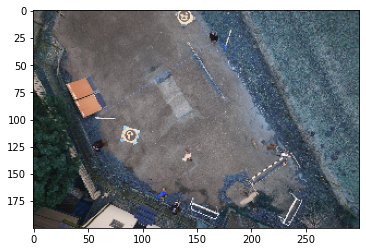

(200, 300, 3)


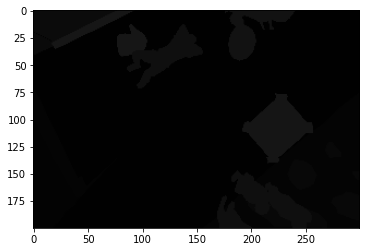

(200, 300, 3)


In [21]:
plt.imshow(original_images[0])
plt.show()
print(original_images[0].shape)
plt.imshow(semantic_images[0])
plt.show()
print(semantic_images[0].shape)
